# Discrete Choice Analysis: micro-econometrics and machine learning approaches

## `Lab session 2B`<br> `Behavioural insights: Using SHAP values to improve model specifications`

**Delft University of Technology**<br>
**July 2022**<br>
**Instructor:** Sander van Cranenburgh <br>
**TAs:**  Francisco Garrido Valenzuela & Lucas Spierenburg <br>

# `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are put to practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

# `Workspace set-up`
**Option 1: Google Colab**<br>
Uncomment the following cell if you are running this notebook on Colab

In [1]:
#!rm -rf /content/ML_approaches_for_discrete_choice_analysis
#!git clone https://github.com/TPM34A/ML_approaches_for_discrete_choice_analysis
#!pip install -r ML_approaches_for_discrete_choice_analysis/requirements_colab.txt
#!cp -R "/content/ML_approaches_for_discrete_choice_analysis/Lab sessions/data" /content/data

**Option 2: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment, to install all dependencies on your Python version.

In [2]:
#!pip install -r requirements_local.txt

# `Application: Swiss mode choice` <br>
In this lab session we will continue analysing mode choices behaviour. However, now our are aim is to obtain behavioural insights from ML models. <br>
To do so, in this lab session you will (1) develop a hybrid ANN-MNL model, and use (2) SHAP values <br>

**Learning objectives**. After completing the following exercises you will be able to: <br>
1. Estimate a  RUM-MNL model using PandasBiogeme (`lab session 2A`)<br>
2. Train hybrid-ANN-MNL models and extract behavioural insights, such as VTTs, from them (`lab session 2A`)<br>
3. Discuss the strength and weaknesses of using fully transparant RUM models, hybrid-models and fully opaque ANNs (`lab session 2A`)<br>
4. **Use SHAP values to obtain behavioural insights from an otherwise opaque ML model**<br>
5. **Use SHAP values to improve the model specification of a theory-driven RUM-MNL discrete choice model**<br>

#### `Organisation`
This lab session comprises **`5`** parts:
1. Preparing your data set
2. Training a XGBoost classifier
3. Evaluating model's pridiction performance
4. Using SHAP values to get insights on global feature importances
5. Using XAI insights to improve model specifications theory-driven discrete choice models

and comprises **`2`** exercises.

In [ ]:
# Import required Python packages and modules
import os
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import getcwd

# Import shap module
import shap

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, log_loss, ConfusionMatrixDisplay, classification_report

# Import XGBoost
from xgboost import XGBClassifier

# Import Biogeme
import biogeme.biogeme as bio
import biogeme.database as db
import biogeme.optimization as opt
import biogeme.messaging as msg
from biogeme import models
from biogeme.expressions import Beta

# Setting
pd.set_option('display.max_columns', None)

### **1. Preparing your data set**
To prepare the data set, we will:<br>
i. **Load** the data set<br>
ii. **Clean** the data and **convert** into a **binary choice** problem<br>
iii. **Splitting** the data in a train set and a test set the data

**i) Load the choice data**

In [4]:
# Get the current working directory
datafile_path = os.path.join(getcwd(),'data','')
print(datafile_path)

/Users/francisco/Desktop/ML_approaches_for_discrete_choice_analysis/Solutions/data/


In [5]:
# Load mode choice data into a pandas DataFrame
df = pd.read_csv(datafile_path + 'swissmetro.dat',sep = '\t')

**ii) Clean the data**

In [6]:
# Data cleaning

# Only keep data for purposes 'Commute" and "Business"
df.drop(df[(df.PURPOSE != 1) & (df.PURPOSE != 3)].index, inplace=True) 

# Drop rows with unknown choices (CHOICE == 0)
df.drop(df[df.CHOICE == 0].index, inplace=True) 

# In case of reamining missing values, replace them with 0
df.fillna(0, inplace = True) 

**Convert the data into a binary choice**<br>
SHAP values are particularly good interpretable for binary choice data (i.e. 2 target classes)<br>
Earlier analysis showed that the RUM-MNL model particularly was doing a poor job in predicting Train. The Recall of the MNL model for train was very low.<br>
We are going to use SHAP to improve this. Therefore, we drop all observations with CHOICE == 'Car' <br>

In [7]:
# Only keep data for TRAIN and SM
# The dataframe with only the 2 alternatives is 'df2'
df2 = df.copy()
df2 = df2.drop(df2[df2.CHOICE == 3].index) 

**iii) Splitting the data in a train set and a test set**<br>
Training ML models always involves a train and a test data set. The former is used to update the weights of the model. Tha latter is used to evaluate the generalisation performance of the model.

In [8]:
# Create X variable containing the features
# The features of CAR are not considered of importance
features = ['PURPOSE', 'FIRST',
            'TICKET', 'WHO', 'LUGGAGE', 'AGE', 
            'MALE', 'INCOME', 'GA', 'ORIGIN', 
            'DEST', 'TRAIN_TT', 'TRAIN_CO', 
            'TRAIN_HE', 'SM_TT', 'SM_CO', 
            'SM_HE', 'SM_SEATS']
X = df2[features]            

# Create the target [0,1]
# 0 = TRAIN
# 1 = SM
Y = df2['CHOICE']-1

# Split the data using sk-learn's `train_test_split` function
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 12345, test_size = 0.4)

### **2. Training a XGBoost classifier**

Since SHAP is model agnostic we can use it any ML model. In this lab session we use an **XGBoost model**. The reason for using XGBoost instead of an ANN is because it gives more illustrative (and better) results, aligning with the educational purpose of this lab session. However, if you have time, you can also replace the XGBoost model with an MLP, and see yourself how it performs.

In [9]:
# Create a XGBoost classifier object using the specified hyperparameters
# Note that for this XGBoost model we do not need to scale the data
# Note the hyperparameter are optimised using a GridSearchCV
# Note you can ignore the meaning of the hyperparameters. We only need the trained classifier.
model = XGBClassifier(eval_metric = 'logloss',colsample_bytree = 0.7, gamma=1.5, max_depth=4, min_child_weight=1, subsample=1)

# Train the XGBoost model
model.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_test, Y_test)],verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=1.5, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

### **3. Evaluating model's pridiction performance**

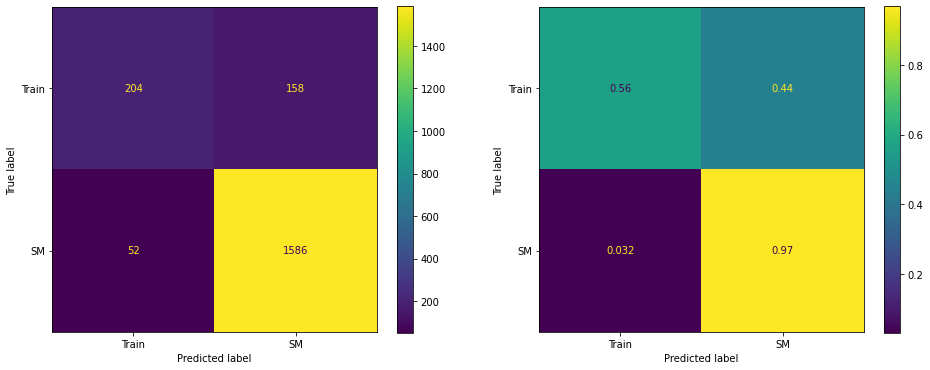

In [10]:
# Predict the choices for the test data set, using the model
Y_pred_test = model.predict(X_test)

# Show the confusion matrices (non-normalised & normalised)
fig, ax = plt.subplots(1,2,figsize = (16,6))
cm1 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_test, display_labels = ['Train', 'SM'], normalize=None,  ax=ax[0])
cm2 = ConfusionMatrixDisplay.from_predictions(y_true=Y_test,y_pred=Y_pred_test, display_labels = ['Train', 'SM'], normalize='true',ax=ax[1])

In [11]:
# To calculate the precision, recal and f1 score we use sk-learn's 'classification_report' functionality
print('Classification report forthe RUM-MNL model\n',
    classification_report(Y_test,Y_pred_test, target_names= ['Train', 'SM']))

Classification report forthe RUM-MNL model
               precision    recall  f1-score   support

       Train       0.80      0.56      0.66       362
          SM       0.91      0.97      0.94      1638

    accuracy                           0.90      2000
   macro avg       0.85      0.77      0.80      2000
weighted avg       0.89      0.90      0.89      2000



### **4. Using SHAP values to get insights on global feature importances**
Next, we are going to compute the SHAP values. To do so, we create a shap explainer object, and provide it with a trained model, and the instances to explain.

In [12]:
# Create the shap explainer object
explainer = shap.Explainer(model, X)

In [13]:
# Apply the explainer to instance(s) X
shap_values = explainer(X)  

#### **Visualising SHAP values**
There are several ways to **visualise** shap explanations. See [the shape documentation website](https://shap.readthedocs.io/en/latest/index.html) for an excellent overview of the use and visualisation of shap values.<br>
Below, we will use the following 3 visualisations: <br> 
1. Bar plot
2. Summary plot
3. Dependence scatter plot

**Bar plot**<br>
The bar plot is the simplest way to visualise feature importances obtained from the shap explainer. Bar plots can be used both for global and local explanations. A larger bar means that knowing the features value has a larger impact on the model's prediction (hence, is more important).

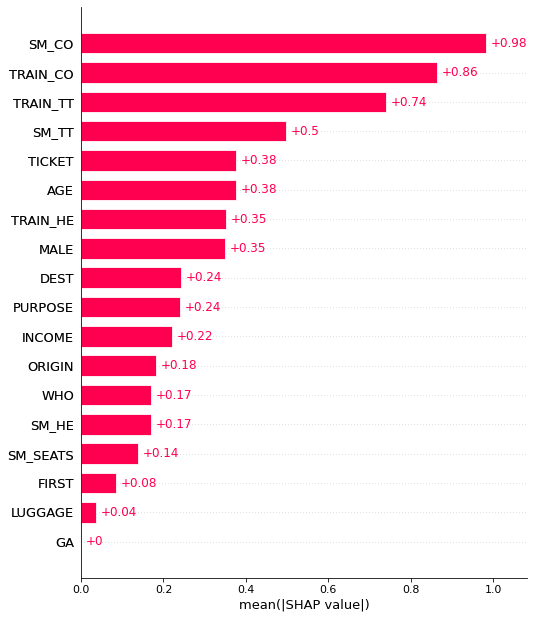

In [14]:
# Plot the feature importances obtained from the shap explainer applied to X
# The plot shows how much knowing that feature’s value changes the output of the model prediction
# Since here we use the full data set (X). The importances show below are global importances. The shap values are avaraged across the instances in X. 
shap.plots.bar(shap_values, max_display=18)

**Summary plot**<br>
Another insightful - but more complex - way to visualise the shap explanations is using the so-called shap summary plot. This plot shows a density scatter plot of shap values for each feature. Each dot represents a shap value explaining an instance of X. What is particularly insightful in this plot is that the color representing the feature value shows the direction of the expected impact on the model's prediction.

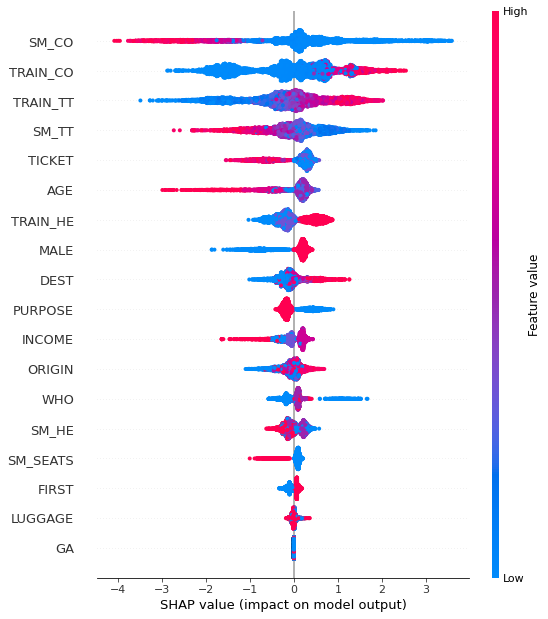

In [15]:
shap.summary_plot(shap_values)

$\color{blue}{\text{In the plot above, the top row shows that a low value of SM\_COST (blue) increase the prediction in the direction of SM.}}$

**Dependence scatter plot**<br>
A dependence scatter plot shows the effect a single feature has on the predictions made by the model. Each dot represents an instance in X.
On the y-axis the shap value is depicted. It shows how much knowing that feature’s value changes the output of the model for an instance in X.

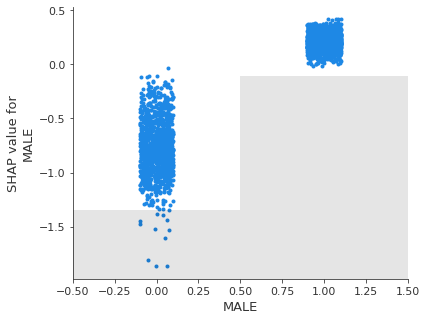

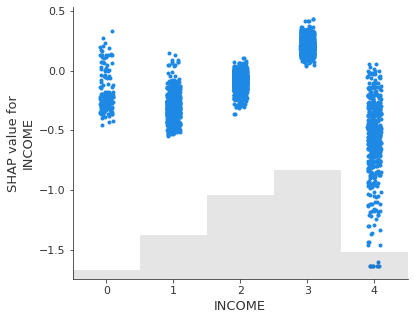

In [16]:
# MALE (0: female, 1: male)
shap.plots.scatter(shap_values[:,"MALE"])
shap.plots.scatter(shap_values[:,"INCOME"])

# Interpretation MALE:
# The partial dependency plot shows Females (0) have a negative SHAP value. The SHAP value represents how much knowing that feature’s value changes the output of the model, and in what direction.
# Because the SHAP value for female is enequal to zero, it suggests the feature MALE has explanatory power in the prediction of the mode choice.
# As the SHAP value is negative for a female, knowing the traveller is female decreases the probability of choosing SM
# Note that MALE is an categorical variable, taking the values {0,1}. In the plot the values seems to deviate on the x-axis. This is only done to improve the visualisation.

# Interpretation INCOME:
# The partial dependency plot shows income level 4 has a negative SHAP value. The SHAP value represents how much knowing that feature’s value changes the output of the model, and in what direction.
# Because the SHAP value for income level 4 is enequal to zero, it suggests the feature INCOME has explanatory power in the prediction of the mode choice.
# As the SHAP value is negative for income level 4, knowing the income is decreases the probability of choosing SM

### `Exercise 1: Dependency plots`<br>
`A` Create dependency plots for other features that are found to impact on the mode choice behaviour<br>
`B` Interpret these dependency plots

$\color{green}{\text{Add your answers here}}$

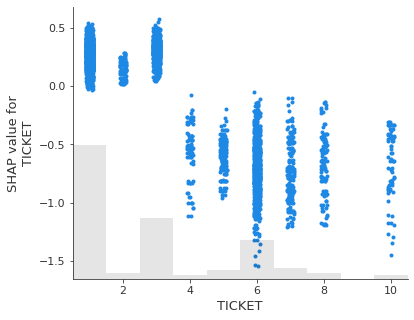

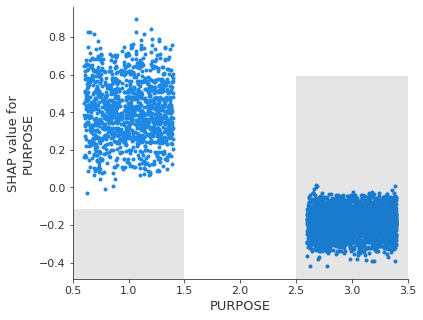

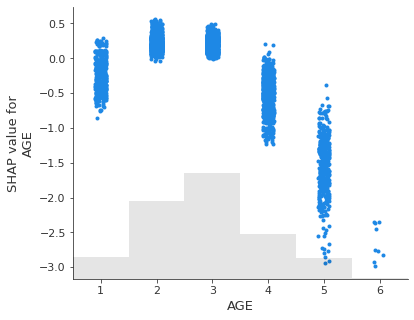

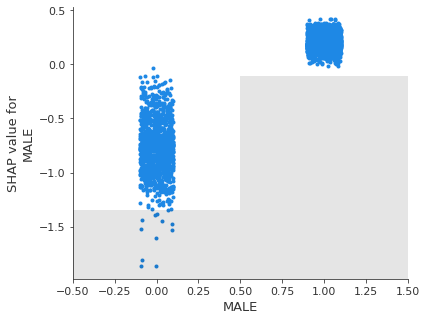

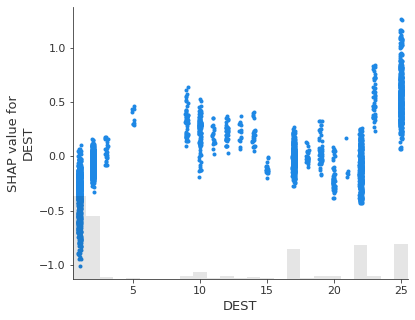

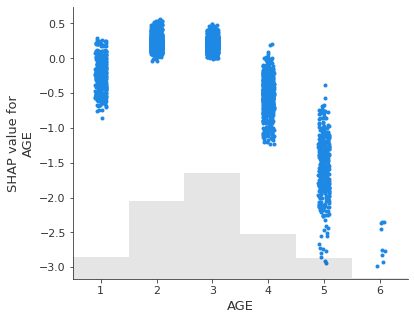

In [17]:
shap.plots.scatter(shap_values[:,"TICKET"])
shap.plots.scatter(shap_values[:,"PURPOSE"])
shap.plots.scatter(shap_values[:,"AGE"])
shap.plots.scatter(shap_values[:,"MALE"])
shap.plots.scatter(shap_values[:,"DEST"])
shap.plots.scatter(shap_values[:,"AGE"])

### **5. Using XAI insights to improve model specifications theory-driven discrete choice models**
One interesting way to use XAI is to use it to improve the model specification of theory-driven discrete choice models. In particular, a choice modeller can use the features that are discovered to be of importance to the ML model to develop a good theory-driven choice model.

### `Exercise 2`
#### **` COMPETITION - Improving the model specification of the theory-driven RUM-MNL discrete choice model`**
Use the behavioural insights obtain from your SHAP analysis AND your choice modelling expertise to improve the model specification / performance of the RUM-MNL discrete choice model. Your model is evaluated based on two criterion:
1. BIC value:<br><br> $BIC = -2\cdot LL + k\cdot ln(N)$, where *N* is the number of observations and *k* the number of estimated parameters.<br><br>
2. Value-of-Travel-Time:<br><br> $VTT = -60\cdot\frac{\beta_{TIME}}{\beta_{COST}}$<br><br>
The **winning model** is the one with the **lowest BIC value** & for which holds **10<VTT<100** Chf/hr <br>

**`The winner obtains a prize, and eternal recognition ;)`**

Note 1: In case you use alternative specific betas for time, then the VTT condition much hold for all modes.<br>
Note 2: Do not use alternative specific betas for cost, as this violates economic rationale.<br>
Note 3: Only RUM-MNL specifications are accepted (thus, mixture models, such as Mixed Logit, or Latent Class models are not admissible)<br>
Note 4: I managed to get to a BIC value of 10,189 and a cross entropy of 0.74 (in 30 minutes of model development). However, in the previous lab session we have seen that the hybrid ANN-MNL and the fully connected ANN both attain a considerably better cross entropy of 0.70 and 0.64, respectively. Therefore, we know there is considerable scope to further improve this specification!<br>

For your convenience, below first the baseline model is provided. Copy this model to a new cell under it, and start gradually improving the model specification.<br>
**GOOD LUCK!!**

**Baseline model**

In [18]:
# Convert pandas df in biogeme database
database = db.Database('swissmetro data', df)

# The following statement allows you to use the names of the variable as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 1)
ASC_SM = Beta('ASC_SM', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)

# Set cost to zero for concession card holders
SM_COST = SM_CO * (GA == 0)             
TRAIN_COST = TRAIN_CO * (GA == 0)       

# Rescale attributes for numerical stability
TRAIN_TT_SCALED   = TRAIN_TT / 100
TRAIN_COST_SCALED = TRAIN_COST / 100
SM_TT_SCALED      = SM_TT / 100
SM_COST_SCALED    = SM_COST / 100
CAR_TT_SCALED     = CAR_TT / 100
CAR_CO_SCALED     = CAR_CO / 100

# Utility functions
V1 = ASC_TRAIN + B_TIME * TRAIN_TT_SCALED + B_COST * TRAIN_COST_SCALED
V2 = ASC_SM    + B_TIME * SM_TT_SCALED    + B_COST * SM_COST_SCALED
V3 = ASC_CAR   + B_TIME * CAR_TT_SCALED   + B_COST * CAR_CO_SCALED

# Associate utility functions with the numbering of alternatives in df.CHOICE
V = {1: V1, 2: V2, 3: V3}

# Associate the availability conditions with the alternatives
AV = {1: TRAIN_AV, 2: SM_AV, 3: CAR_AV}

# Definition of the model. This is the contribution of each observation to the log likelihood function.
logprob = models.loglogit(V, AV, CHOICE)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'RUM-MNL model with TRAIN and SM'
biogeme.generatePickle = False
biogeme.generateHtml = False

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(AV)

# Estimate the parameters
results = biogeme.estimate()

# Report the results in a pandas table
print('Estimated parameters')
print('----------')
print(results.getEstimatedParameters()[['Value','Std err','t-test','p-value']])

Estimated parameters
----------
            Value   Std err     t-test  p-value
ASC_CAR  0.546555  0.046115  11.851988      0.0
ASC_SM   0.701187  0.054874  12.778150      0.0
B_COST  -1.083790  0.051830 -20.910405      0.0
B_TIME  -1.277859  0.056883 -22.464561      0.0


In [19]:
# Show the model performance
print(results.shortSummary())

# Compute and print the cross entropy
cross_entropy =  -(results.getGeneralStatistics()['Final log likelihood'][0])/(results.getGeneralStatistics()['Sample size'][0])
print(f'Cross entropy:\t\t\t {cross_entropy:.3f}')

# Compute the Value-of-Travel Time: (60*beta_TIME/beta_COST)
betas = results.getBetaValues()
VTT   = 60*betas['B_TIME']/(betas['B_COST'])
print(f'\nThe Value-of-Travel-Time = {VTT:.3f} chf/hr.')

Results for model RUM-MNL model with TRAIN and SM
Nbr of parameters:		4
Sample size:			6768
Excluded data:			0
Null log likelihood:		-6964.663
Final log likelihood:		-5331.252
Likelihood ratio test (null):		3266.822
Rho square (null):			0.235
Rho bar square (null):			0.234
Akaike Information Criterion:	10670.5
Bayesian Information Criterion:	10697.78

Cross entropy:			 0.788

The Value-of-Travel-Time = 70.744 chf/hr.


$\color{green}{\text{Add your answers here}}$

In [20]:
# Convert pandas df in biogeme database
database = db.Database('swissmetro data', df)

# The following statement allows you to use the names of the variable as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_CAR = Beta('ASC_CAR', 0, None, None, 0)
ASC_TRAIN = Beta('ASC_TRAIN', 0, None, None, 1)
ASC_SM = Beta('ASC_SM', 0, None, None, 0)
B_TIME_TR = Beta('B_TIME_TR', 0, None, None, 0)
B_TIME_SM = Beta('B_TIME_SM', 0, None, None, 0)
B_TIME_CAR = Beta('B_TIME_CAR', 0, None, None, 0)
B_COST = Beta('B_COST', 0, None, None, 0)
B_HE_TR = Beta('B_HE_TR', 0, None, None, 0)
B_HE_SM = Beta('B_HE_SM', 0, None, None, 0)
B_DEST1 = Beta('B_DEST1', 0, None, None, 0)
B_DEST25 = Beta('B_DEST25', 0, None, None, 0)
B_AGE = Beta('B_AGE', 0, None, None, 0)
B_INC4 = Beta('B_INC4', 0, None, None, 0)
B_PURP = Beta('B_PURP', 0, None, None, 0)
B_TICK = Beta('B_TICK', 0, None, None, 0)
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_WHO = Beta('B_WHO', 0, None, None, 0)
B_SM_SEATS = Beta('B_SM_SEATS', 0, None, None, 0)
B_ORIG1 = Beta('B_ORIG1', 0, None, None, 0)

# Set cost to zero for concession card holders
SM_COST = SM_CO * (GA == 0)             
TRAIN_COST = TRAIN_CO * (GA == 0)       

# Rescale attributes for numerical stability
TRAIN_TT_SCALED   = TRAIN_TT / 100
TRAIN_COST_SCALED = TRAIN_COST / 100
SM_TT_SCALED      = SM_TT / 100
SM_COST_SCALED    = SM_COST / 100
CAR_TT_SCALED     = CAR_TT / 100
CAR_CO_SCALED     = CAR_CO / 100

# Utility functions
V1 = ASC_TRAIN + B_TIME_TR * TRAIN_TT_SCALED + B_COST * TRAIN_COST_SCALED + B_HE_TR * TRAIN_HE   + B_MALE * (MALE == 0)  + B_INC4 * (INCOME==4) + B_AGE * AGE + B_DEST1 * (DEST==1) + B_PURP * (PURPOSE == 1) + B_TICK * (TICKET>=3) + B_ORIG1 * (ORIGIN==1)
V2 = ASC_SM    + B_TIME_SM * SM_TT_SCALED    + B_COST * SM_COST_SCALED + B_HE_SM * SM_HE      + B_DEST25 * (DEST==25)  + B_WHO * (WHO ==0) + B_SM_SEATS * (SM_SEATS==1)
V3 = ASC_CAR   + B_TIME_CAR * CAR_TT_SCALED   + B_COST * CAR_CO_SCALED

# Associate utility functions with the numbering of alternatives in df.CHOICE
V = {1: V1, 2: V2, 3: V3}

# Associate the availability conditions with the alternatives
AV = {1: TRAIN_AV, 2: SM_AV, 3: CAR_AV}

# Definition of the model. This is the contribution of each observation to the log likelihood function.
logprob = models.loglogit(V, AV, CHOICE)

# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'RUM-MNL model with SHAP informed utility specification'
biogeme.generatePickle = False
biogeme.generateHtml = False

# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(AV)

# Estimate the parameters
results = biogeme.estimate()

# Report the results in a pandas table
print('Estimated parameters')
print('----------')
print(results.getEstimatedParameters()[['Value','Std err','t-test','p-value']])

Estimated parameters
----------
               Value   Std err     t-test       p-value
ASC_CAR     1.407819  0.199891   7.042926  1.882494e-12
ASC_SM      1.874787  0.204584   9.163922  0.000000e+00
B_AGE       0.310399  0.035145   8.832004  0.000000e+00
B_COST     -1.121632  0.052204 -21.485401  0.000000e+00
B_DEST1     0.017290  0.093305   0.185311  8.529854e-01
B_DEST25    0.231469  0.089358   2.590340  9.588113e-03
B_HE_SM    -0.007905  0.003324  -2.378338  1.739089e-02
B_HE_TR    -0.006321  0.001092  -5.789530  7.058357e-09
B_INC4      0.837783  0.115154   7.275344  3.455014e-13
B_MALE      1.071240  0.085325  12.554793  0.000000e+00
B_ORIG1     0.339955  0.100798   3.372621  7.445631e-04
B_PURP     -0.573028  0.100089  -5.725183  1.033220e-08
B_SM_SEATS -0.124942  0.090333  -1.383126  1.666264e-01
B_TICK      0.905938  0.083293  10.876554  0.000000e+00
B_TIME_CAR -1.097476  0.063704 -17.227620  0.000000e+00
B_TIME_SM  -1.166408  0.088428 -13.190559  0.000000e+00
B_TIME_TR  -1.50

In [21]:
# Show the model performance
print(results.shortSummary())

# Compute and print the cross entropy
cross_entropy =  -(results.getGeneralStatistics()['Final log likelihood'][0])/(results.getGeneralStatistics()['Sample size'][0])
print(f'Cross entropy:\t\t\t {cross_entropy:.3f}')

# Compute the Value-of-Travel Time: (60*beta_TIME/beta_COST)
betas = results.getBetaValues()
VTT_TRAIN   = 60*betas['B_TIME_TR']/(betas['B_COST'])
VTT_SM      = 60*betas['B_TIME_SM']/(betas['B_COST'])
VTT_CAR     = 60*betas['B_TIME_CAR']/(betas['B_COST'])
print(f'\nThe Value-of-Travel-Time TRAIN =\t {VTT_TRAIN:.3f} chf/hr.')
print(f'\nThe Value-of-Travel-Time SM =\t\t {VTT_SM:.3f} chf/hr.')
print(f'\nThe Value-of-Travel-Time CAR =\t\t {VTT_CAR:.3f} chf/hr.')

Results for model RUM-MNL model with SHAP informed utility specification
Nbr of parameters:		18
Sample size:			6768
Excluded data:			0
Null log likelihood:		-6964.663
Final log likelihood:		-5015.01
Likelihood ratio test (null):		3899.306
Rho square (null):			0.28
Rho bar square (null):			0.277
Akaike Information Criterion:	10066.02
Bayesian Information Criterion:	10188.78

Cross entropy:			 0.741

The Value-of-Travel-Time TRAIN =	 80.366 chf/hr.

The Value-of-Travel-Time SM =		 62.395 chf/hr.

The Value-of-Travel-Time CAR =		 58.708 chf/hr.
